In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import cv2
import os 

import warnings
# Ignorar todos los warnings
warnings.filterwarnings('ignore')

# El dataset

https://www.kaggle.com/datasets/victordibia/signverod/data

Detectar la presencia y la ubicación de elementos escritos a mano, como firmas, fechas o iniciales, puede ser fundamental para los sistemas de tratamiento de documentos escaneados (offline). Esta capacidad puede contribuir a múltiples tareas posteriores, como la verificación de firmas, el etiquetado de documentos y la categorización. En este trabajo presentamos SignverOD, un conjunto de datos de 2576 imágenes de documentos escaneados con 7103 anotaciones en recuadros delimitadores, en 4 categorías (firma, iniciales, redacción, fecha). SignverOD abarca diversos tipos de documentos, como notas, correos electrónicos, cheques bancarios, contratos de arrendamiento y cartas, memorandos y facturas. 


## construyendo el dataset

**IMPORTANTE** Estan mezclados los nombres image_id del primer df con el id del segundo: voy corregir esto: 

In [2]:
data_path = '../data/signature_detection/signverod/'
data_file1 = 'full_data.csv'
data_file2 = 'updated_image_ids.csv'

full_path1 = os.path.join(data_path, data_file1)
full_path2 = os.path.join(data_path, data_file2)

full_df = pd.read_csv(full_path1)
print(len(full_df))
mapp_full_df = pd.read_csv(full_path2)
print(len(mapp_full_df))

display(full_df.tail())
display(mapp_full_df.tail())

8022
2765


,area,bbox,category_id,id,image_id
8017,0.007,"[0.6934562775633958, 0.12426133943781942, 0.12...",4,8018,2764
8018,0.019,"[0.11324846903483073, 0.6288094274776498, 0.30...",1,8019,2765
8019,0.015,"[0.10043294270833333, 0.7067381868657377, 0.26...",1,8020,2765
8020,0.005,"[0.6154690945424476, 0.09168707410562181, 0.07...",4,8021,2765
8021,0.014,"[0.14775272188533628, 0.7427597955706985, 0.12...",1,8022,2765


,height,width,id,file_name
2760,4428.0,3445.0,2761,gsa_LAZ02191-SLA-4-_Z-01.png
2761,4400.0,3400.0,2762,gsa_LAZ01910-SLA-20-_Z-01.png
2762,4400.0,3400.0,2763,gsa_LAR16487-SLA-05-_Z-01.png
2763,4400.0,3400.0,2764,gsa_LAZ01846-SLA-3-_Z-01.png
2764,4400.0,3400.0,2765,gsa_LAR17002-SLA-1-_Z-01.png


In [3]:
print(full_df.info())
print(mapp_full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8022 entries, 0 to 8021
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   area         8022 non-null   float64
 1   bbox         8022 non-null   object 
 2   category_id  8022 non-null   int64  
 3   id           8022 non-null   int64  
 4   image_id     8022 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 313.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 0 to 2764
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   height     2765 non-null   float64
 1   width      2765 non-null   float64
 2   id         2765 non-null   int64  
 3   file_name  2765 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 86.5+ KB
None


## voy a unir el dataset para inspeccionarlo

In [4]:
full_df.drop('id', axis= 1, inplace= True)
full_df['category']= full_df['category_id'].map({1:'signature', 2:'initials', 3:'redaction', 4:'date'})
full_df['category_id']= full_df['category_id'].map({1:0, 2:1, 3:2, 4:3})
display(full_df.tail())

mapp_full_df = mapp_full_df.rename(columns= {'id': 'image_id'})
mapp_full_df.tail()

,area,bbox,category_id,image_id,category
8017,0.007,"[0.6934562775633958, 0.12426133943781942, 0.12...",3,2764,date
8018,0.019,"[0.11324846903483073, 0.6288094274776498, 0.30...",0,2765,signature
8019,0.015,"[0.10043294270833333, 0.7067381868657377, 0.26...",0,2765,signature
8020,0.005,"[0.6154690945424476, 0.09168707410562181, 0.07...",3,2765,date
8021,0.014,"[0.14775272188533628, 0.7427597955706985, 0.12...",0,2765,signature


,height,width,image_id,file_name
2760,4428.0,3445.0,2761,gsa_LAZ02191-SLA-4-_Z-01.png
2761,4400.0,3400.0,2762,gsa_LAZ01910-SLA-20-_Z-01.png
2762,4400.0,3400.0,2763,gsa_LAR16487-SLA-05-_Z-01.png
2763,4400.0,3400.0,2764,gsa_LAZ01846-SLA-3-_Z-01.png
2764,4400.0,3400.0,2765,gsa_LAR17002-SLA-1-_Z-01.png


In [5]:
data = pd.merge(full_df, mapp_full_df, on='image_id')
#data.drop('id', axis= 1, inplace= True)
data.head()

,area,bbox,category_id,image_id,category,height,width,file_name
0,0.007,"[0.1444945139800141, 0.8143371482168966, 0.284...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
1,0.011,"[0.19762310567116137, 0.869482544646866, 0.354...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
2,0.007,"[0.13856792273017163, 0.8392342753794001, 0.23...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
3,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",0,2,signature,3300.0,2560.0,nist_r0647_01.png
4,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",0,2,signature,3300.0,2560.0,nist_r0647_01.png


In [6]:
data['category_id'].value_counts()

category_id
0    4551
2    1912
1     989
3     570
Name: count, dtype: int64

In [7]:
signature_data = data[data['category_id'] == 0]

## Inspeccionando el dataset

In [8]:
signature_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4551 entries, 0 to 8021
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   area         4551 non-null   float64
 1   bbox         4551 non-null   object 
 2   category_id  4551 non-null   int64  
 3   image_id     4551 non-null   int64  
 4   category     4551 non-null   object 
 5   height       4551 non-null   float64
 6   width        4551 non-null   float64
 7   file_name    4551 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 320.0+ KB


### BBOX Format

In [9]:
print(eval(signature_data.loc[0,'bbox']))
type(eval(signature_data.loc[0,'bbox']))

[0.1444945139800141, 0.8143371482168966, 0.2842842522428135, 0.023742864009066555]


list

In [10]:
signature_data.loc[3]

area                                                       0.009
bbox           [0.14669516046674358, 0.8172596266496202, 0.33...
category_id                                                    0
image_id                                                       2
category                                               signature
height                                                    3300.0
width                                                     2560.0
file_name                                      nist_r0647_01.png
Name: 3, dtype: object

In [11]:
bbox_matrix = signature_data['bbox'].apply(lambda x: np.array(eval(x)))

print(bbox_matrix.values)

[array([0.14449451, 0.81433715, 0.28428425, 0.02374286])
 array([0.19762311, 0.86948254, 0.35451038, 0.02996967])
 array([0.13856792, 0.83923428, 0.23733628, 0.02964888]) ...
 array([0.11324847, 0.62880943, 0.30207504, 0.06190192])
 array([0.10043294, 0.70673819, 0.26391591, 0.05519324])
 array([0.14775272, 0.7427598 , 0.12783817, 0.10808733])]


In [12]:
paths = [path[0] for path in data.groupby('file_name')['image_id'].value_counts().index[::]]
print(len(paths) == len(np.unique(paths)))

True


In [13]:
from random import choice

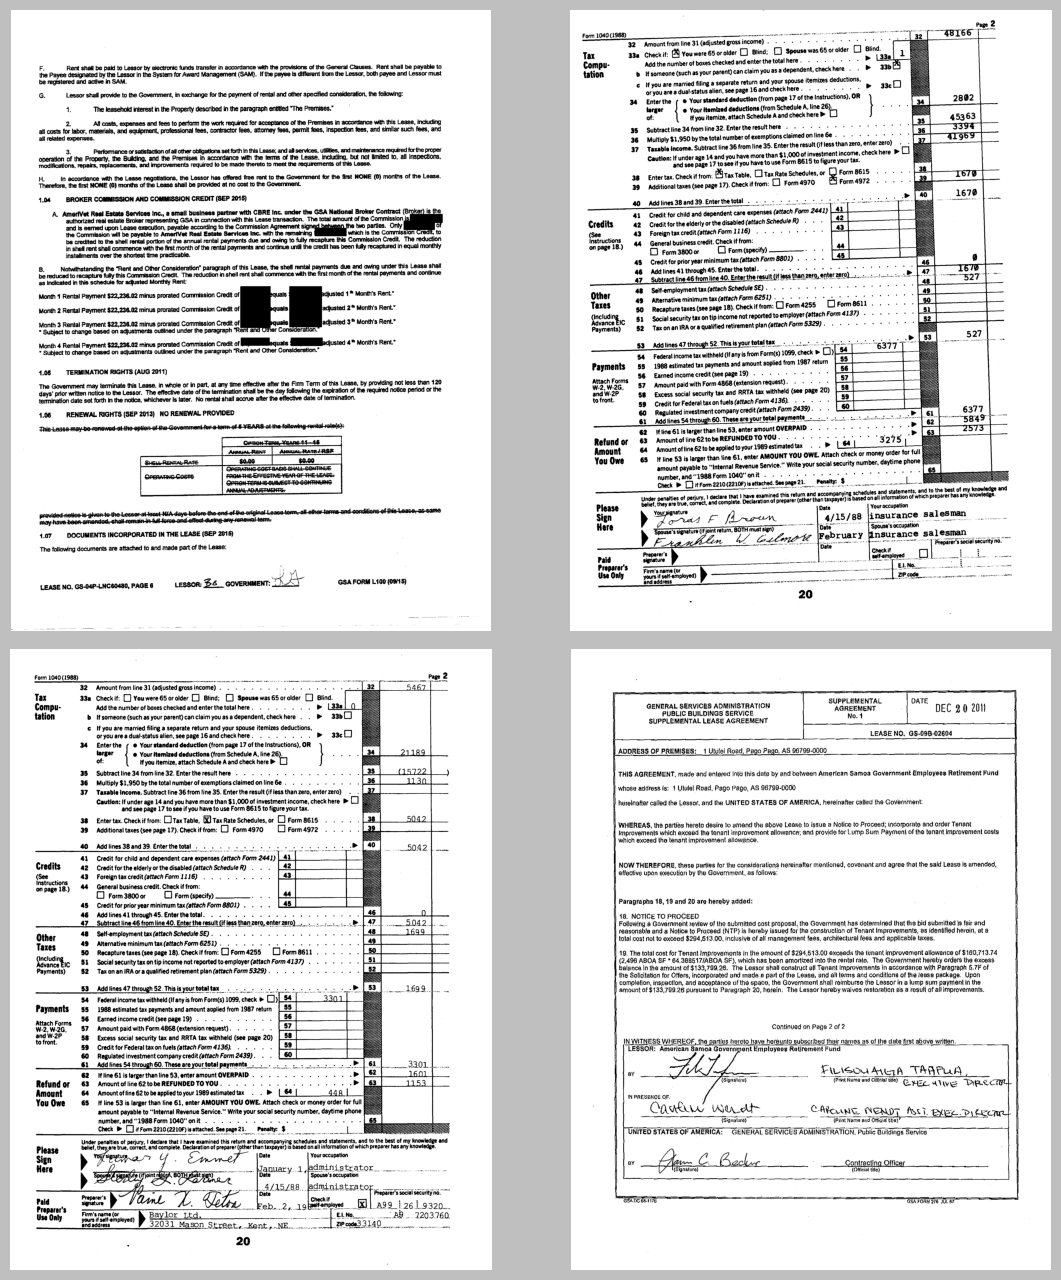

In [14]:

posible_choices = paths.copy()

n_rows = 2
n_cols = 2
plt.style.use('grayscale')
plt.figure(figsize=(n_cols * 8, n_rows * 7))
# plt.title('Muestra de documentos', fontdict= {'fontsize': 20, 'fontstyle':'italic', 'y':1.1})
# plt.grid(False)

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)

        random_img = choice(posible_choices)
        img_path = '../data/signature_detection/signverod/images/' + random_img
        posible_choices.remove(random_img)

        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Agrega esta línea

        plt.imshow(img)
        plt.axis('off')
        #plt.title(random_img)
plt.subplots_adjust(
    wspace=0.0001,  # Espacio horizontal más pequeño entre subfiguras
    hspace=0.03,  # Espacio vertical más pequeño entre subfiguras
    left=0.1,   # Menos espacio en el margen izquierdo
    right=0.8,  # Menos espacio en el margen derecho
    top=0.95,    # Menos espacio en el margen superior
    bottom=0.05  # Menos espacio en el margen inferior
)
plt.show()

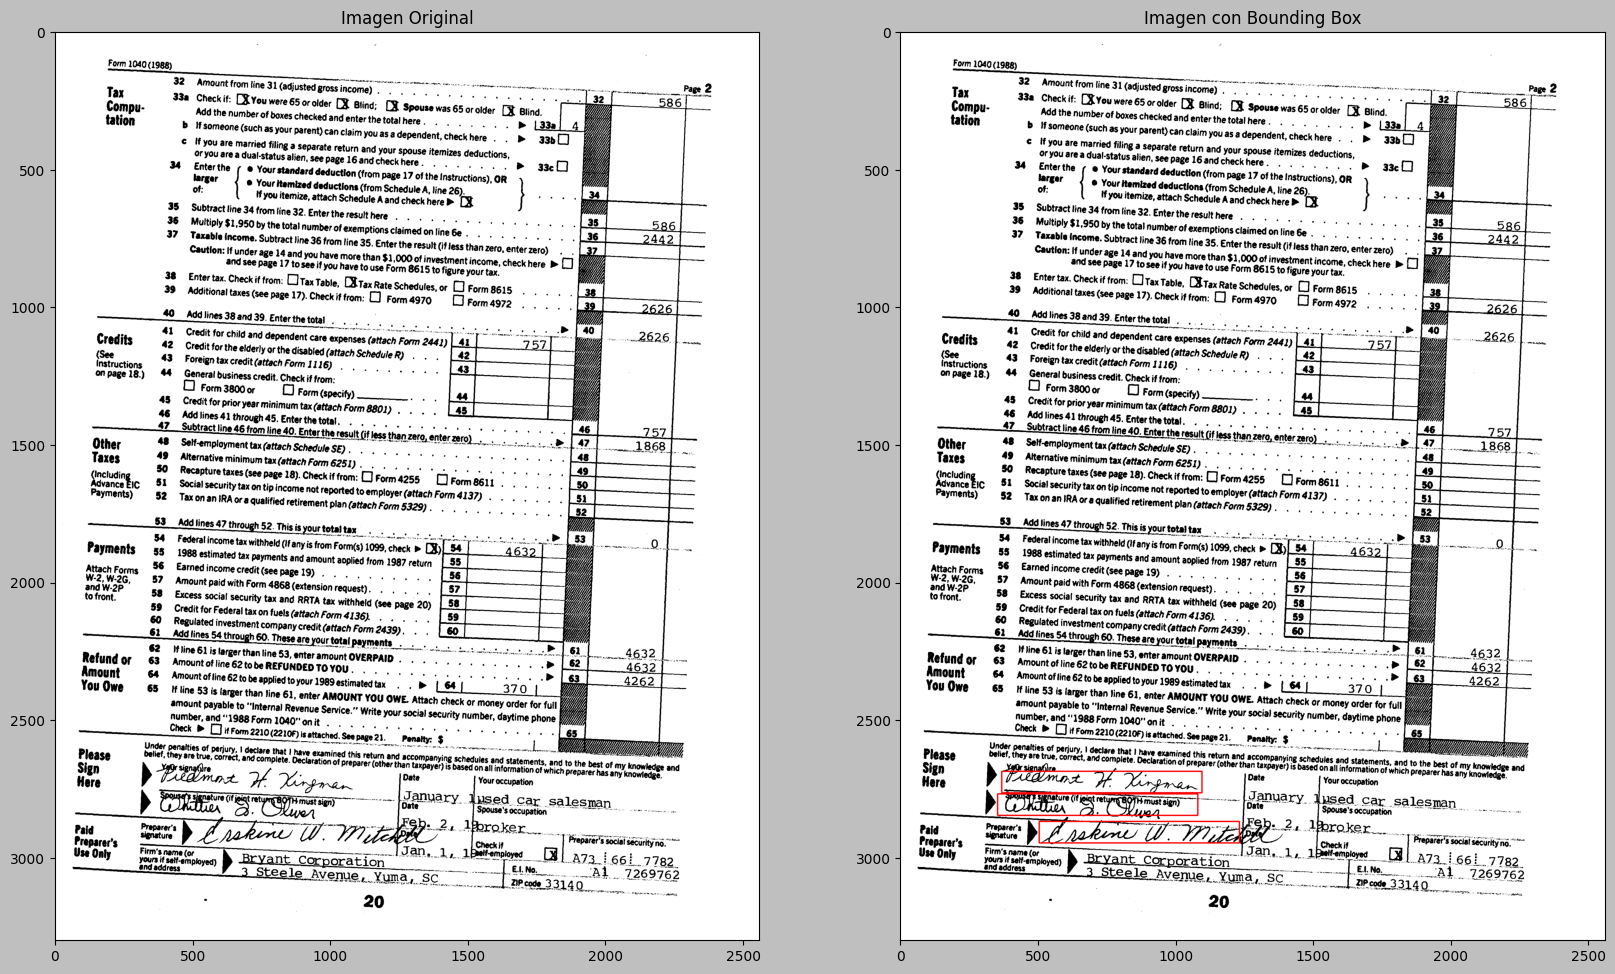

In [15]:
np.random.seed(41)

sample = data.loc[0]
file_name = sample['file_name']
# print(file_name)
img_path = '../data/signature_detection/signverod/images/' + file_name


bbox = eval(sample['bbox'])
bbox2 = eval(data.loc[1,'bbox'])
bbox3 = eval(data.loc[2,'bbox'])
#print(bbox)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, _ = img.shape  # Obtener dimensiones de la imagen

x_min = int(bbox[0] * width)
y_min = int(bbox[1] * height)
ancho = int(bbox[2] * width)
alto = int(bbox[3] * height)

x_min2 = int(bbox2[0] * width)
y_min2 = int(bbox2[1] * height)
ancho2 = int(bbox2[2] * width)
alto2 = int(bbox2[3] * height)

x_min3 = int(bbox3[0] * width)
y_min3 = int(bbox3[1] * height)
ancho3 = int(bbox3[2] * width)
alto3 = int(bbox3[3] * height)

# Calcular el punto final (x_max, y_max) en píxeles basado en el ancho y alto
x_max = x_min + ancho
y_max = y_min + alto

x_max2 = x_min2 + ancho
y_max2 = y_min2 + alto

x_max3 = x_min3 + ancho
y_max3 = y_min3 + alto

# Dibujar la bounding box en la imagen
start_point = (x_min, y_min)  # Punto inicial en píxeles
end_point = (x_max, y_max)  # Punto final en píxeles

start_point2 = (x_min2, y_min2)  # Punto inicial en píxeles
end_point2 = (x_max2, y_max2)  # Punto final en píxeles

start_point3 = (x_min3, y_min3)  # Punto inicial en píxeles
end_point3 = (x_max3, y_max3)  # Punto final en píxeles

img_bbox = img.copy()

color = (255, 0, 0)  # Color rojo para la bounding box
thickness = 3  # Grosor de la línea
cv2.rectangle(img_bbox, start_point, end_point, color, thickness)
cv2.rectangle(img_bbox, start_point2, end_point2, color, thickness)
cv2.rectangle(img_bbox, start_point3, end_point3, color, thickness)

# Plotear las imágenes
plt.figure(figsize=(20, 13))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(img_bbox)
plt.title('Imagen con Bounding Box')

plt.show()
# plt.figure(figsize= (15,10))
# plt.title('Un documento aleatorio', fontsize= 18)
# plt.imshow(img_bbox)
# plt.show()

El siguiente codigo da error por que posteriormente he cambiado los directorios de las imagenes y esta intentando coger imagenes de diferentes directorios...

In [16]:
# n_rows = 3
# n_cols = 3
# plt.figure(figsize=(n_cols * 7, n_rows * 4))

# for row in range(n_rows):
#     for col in range(n_cols):
#         index = n_cols * row + col
#         plt.subplot(n_rows, n_cols, index + 1)

#         random_img = signature_data.sample(1)

        
#         file_name = random_img['file_name'].values[0]
#         # print(file_name)
#         img_path = '../data/signature_detection/signverod/images/train/' + file_name


#         bbox = eval(random_img['bbox'].values[0])
#         #print(bbox)


#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Agrega esta línea
#         height, width, _ = img.shape  # Obtener dimensiones de la imagen

#         x_min = int(bbox[0] * width)
#         y_min = int(bbox[1] * height)
#         ancho = int(bbox[2] * width)
#         alto = int(bbox[3] * height)

#         # Calcular el punto final (x_max, y_max) en píxeles basado en el ancho y alto
#         x_max = x_min + ancho
#         y_max = y_min + alto

#         # Dibujar la bounding box en la imagen
#         start_point = (x_min, y_min)  # Punto inicial en píxeles
#         end_point = (x_max, y_max)  # Punto final en píxeles
#         color = (255, 0, 0)  # Color rojo para la bounding box
#         thickness = 5  # Grosor de la línea
#         img_bbox = cv2.rectangle(img.copy(), start_point, end_point, color, thickness)

#         plt.imshow(img_bbox)
#         plt.axis('off')
        
# plt.subplots_adjust(wspace=0.01, hspace=0.1)
# plt.show()

## Pasando los datos a formtato YOLO: 

Ahora que hemos comprobado que las bboxes estan en formato correcto asociadas a las imagenes correctas hay que pasar los datos a un formato que YOLO pueda gestionar.

Para cada imagen en tu conjunto de datos, YOLO espera un archivo de anotaciones correspondiente con el mismo nombre que la imagen, pero con la extensión .txt en lugar de la extensión de la imagen (por ejemplo, .jpg o .png). Cada línea en este archivo de texto representa un objeto detectado en la imagen y debe seguir el formato:

**class_id x_center y_center width height**

Donde:

- <class_id> es el identificador de la clase del objeto, comenzando por 0.
- <x_center>, <y_center>, <width>, <height> son las coordenadas y dimensiones de la bounding box, normalizadas respecto al tamaño de la imagen (valores entre 0 y 1). <x_center> y <y_center> representan el centro de la bounding box, mientras que <width> y <height> son el ancho y alto de la caja, respectivamente.

### Ejemplo de Archivo de Anotación

Supongamos que tienes una imagen llamada documento1.jpg de tamaño 1000x1000 px, con una firma y una fecha detectadas. La firma tiene una bounding box de (50, 200, 400, 100) y la fecha (700, 50, 200, 50) en coordenadas no normalizadas (x_min, y_min, width, height). Primero, convertirías estas coordenadas a valores normalizados y luego crearías un archivo documento1.txt con el contenido:

0 0.25 0.25 0.4 0.1
1 0.8 0.075 0.2 0.05

Asumiendo que 0 es el ID para "firma" y 1 es el ID para "fecha".


### Estructura de los directorios

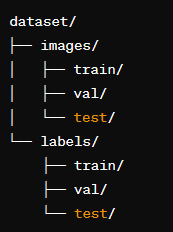

In [16]:
data.head(10)

,area,bbox,category_id,image_id,category,height,width,file_name
0,0.007,"[0.1444945139800141, 0.8143371482168966, 0.284...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
1,0.011,"[0.19762310567116137, 0.869482544646866, 0.354...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
2,0.007,"[0.13856792273017163, 0.8392342753794001, 0.23...",0,1,signature,3300.0,2560.0,nist_r0392_01.png
3,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",0,2,signature,3300.0,2560.0,nist_r0647_01.png
4,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",0,2,signature,3300.0,2560.0,nist_r0647_01.png
5,0.008,"[0.21358420632102273, 0.8757179542824074, 0.23...",0,2,signature,3300.0,2560.0,nist_r0647_01.png
6,0.006,"[0.5366111738148984, 0.899244842346794, 0.0856...",1,3,initials,4454.0,3480.0,gsa_LAL50113-Lease-_Z-03.png
7,0.005,"[0.6299114700902935, 0.90049396494709, 0.06553...",1,3,initials,4454.0,3480.0,gsa_LAL50113-Lease-_Z-03.png
8,0.009,"[0.14191772299624344, 0.8094503897207754, 0.28...",0,4,signature,3300.0,2560.0,nist_r0169_01.png
9,0.007,"[0.16751928944007308, 0.8457117151331018, 0.25...",0,4,signature,3300.0,2560.0,nist_r0169_01.png


In [17]:
def convert_to_yolo_format(bbox_str):
    bbox = eval(bbox_str)
    x_min_norm, y_min_norm, width_norm, height_norm = bbox
    
    # Calcular el centro de la bbox (normalizado)
    x_center_norm = x_min_norm + width_norm / 2
    y_center_norm = y_min_norm + height_norm / 2
    
    # Devolver en el formato esperado por YOLO
    return [x_center_norm, y_center_norm, width_norm, height_norm]

data['yolo_bbox'] = data['bbox'].apply(lambda row: convert_to_yolo_format(row))

data.head()

,area,bbox,category_id,image_id,category,height,width,file_name,yolo_bbox
0,0.007,"[0.1444945139800141, 0.8143371482168966, 0.284...",0,1,signature,3300.0,2560.0,nist_r0392_01.png,"[0.28663664010142087, 0.8262085802214298, 0.28..."
1,0.011,"[0.19762310567116137, 0.869482544646866, 0.354...",0,1,signature,3300.0,2560.0,nist_r0392_01.png,"[0.37487829444609777, 0.8844673799129692, 0.35..."
2,0.007,"[0.13856792273017163, 0.8392342753794001, 0.23...",0,1,signature,3300.0,2560.0,nist_r0392_01.png,"[0.25723606314862596, 0.854058715118759, 0.237..."
3,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",0,2,signature,3300.0,2560.0,nist_r0647_01.png,"[0.31662915823514953, 0.8307790194156666, 0.33..."
4,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",0,2,signature,3300.0,2560.0,nist_r0647_01.png,"[0.3298696855608927, 0.8660222936559606, 0.293..."


In [18]:
final_data = data[['image_id', 'file_name', 'category_id', 'yolo_bbox', 'height', 'width']]
final_data.head()

,image_id,file_name,category_id,yolo_bbox,height,width
0,1,nist_r0392_01.png,0,"[0.28663664010142087, 0.8262085802214298, 0.28...",3300.0,2560.0
1,1,nist_r0392_01.png,0,"[0.37487829444609777, 0.8844673799129692, 0.35...",3300.0,2560.0
2,1,nist_r0392_01.png,0,"[0.25723606314862596, 0.854058715118759, 0.237...",3300.0,2560.0
3,2,nist_r0647_01.png,0,"[0.31662915823514953, 0.8307790194156666, 0.33...",3300.0,2560.0
4,2,nist_r0647_01.png,0,"[0.3298696855608927, 0.8660222936559606, 0.293...",3300.0,2560.0


In [19]:
final_data.tail()

,image_id,file_name,category_id,yolo_bbox,height,width
8017,2764,gsa_LAZ01846-SLA-3-_Z-01.png,3,"[0.7562642123759646, 0.15067677278534924, 0.12...",4400.0,3400.0
8018,2765,gsa_LAR17002-SLA-1-_Z-01.png,0,"[0.2642859903971354, 0.6597603866734456, 0.302...",4400.0,3400.0
8019,2765,gsa_LAR17002-SLA-1-_Z-01.png,0,"[0.23239089965820312, 0.7343348080349952, 0.26...",4400.0,3400.0
8020,2765,gsa_LAR17002-SLA-1-_Z-01.png,3,"[0.6542538071940462, 0.12218344069420783, 0.07...",4400.0,3400.0
8021,2765,gsa_LAR17002-SLA-1-_Z-01.png,0,"[0.21167180609151048, 0.7968034630536627, 0.12...",4400.0,3400.0


## Particion de los datos

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = final_data[['image_id', 'file_name']]
y = final_data[['image_id', 'category_id', 'yolo_bbox']]

unique_imgs = final_data['image_id'].unique()

train_imgs_full, test_imgs = train_test_split(unique_imgs, test_size=0.2, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs_full, test_size=0.2, random_state=42)


train_data = final_data[final_data['image_id'].isin(train_imgs)]
val_data = final_data[final_data['image_id'].isin(val_imgs)]
test_data = final_data[final_data['image_id'].isin(test_imgs)]

# guardar los splits en el pc
path_to_data = 'C:/Users/plane/OneDrive/Escritorio/COMPUTING SCIENCE/TFM_transformer_agents/data/signature_detection'
train_data_file = 'train_data.pickle'
val_data_file = 'val_data.pickle'
test_data_file = 'test_data.pickle'

# train_data.to_pickle(os.path.join(path_to_data, train_data_file))
# val_data.to_pickle(os.path.join(path_to_data, val_data_file))
# test_data.to_pickle(os.path.join(path_to_data, test_data_file))

X_train = X[X['image_id'].isin(train_imgs)]
y_train = y[y['image_id'].isin(train_imgs)]

X_val = X[X['image_id'].isin(val_imgs)]
y_val = y[y['image_id'].isin(val_imgs)]

X_test = X[X['image_id'].isin(test_imgs)]
y_test = y[y['image_id'].isin(test_imgs)]

In [23]:
print('TRAIN')
print(X_train.shape, y_train.shape)
display(X_train.head(7))
display(y_train.head(7))
#display(X_train.tail())
print('VALID')
print(X_val.shape, y_val.shape)
display(X_val.head(7))
display(y_val.head(7))
print('TEST')
print(X_test.shape, y_test.shape)
display(X_test.head(7))
display(y_test.head(7))

TRAIN
(5156, 2) (5156, 3)


,image_id,file_name
0,1,nist_r0392_01.png
1,1,nist_r0392_01.png
2,1,nist_r0392_01.png
6,3,gsa_LAL50113-Lease-_Z-03.png
7,3,gsa_LAL50113-Lease-_Z-03.png
8,4,nist_r0169_01.png
9,4,nist_r0169_01.png


,image_id,category_id,yolo_bbox
0,1,0,"[0.28663664010142087, 0.8262085802214298, 0.28..."
1,1,0,"[0.37487829444609777, 0.8844673799129692, 0.35..."
2,1,0,"[0.25723606314862596, 0.854058715118759, 0.237..."
6,3,1,"[0.5794410447234764, 0.9321397292287499, 0.085..."
7,3,1,"[0.6626803223758465, 0.9362116953262787, 0.065..."
8,4,0,"[0.2827883633580188, 0.8257092594582542, 0.281..."
9,4,0,"[0.29298852451661317, 0.8599852385344329, 0.25..."


VALID
(1321, 2) (1321, 3)


,image_id,file_name
3,2,nist_r0647_01.png
4,2,nist_r0647_01.png
5,2,nist_r0647_01.png
18,6,nist_r0812_01.png
19,6,nist_r0812_01.png
20,6,nist_r0812_01.png
41,16,nist_r0207_01.png


,image_id,category_id,yolo_bbox
3,2,0,"[0.31662915823514953, 0.8307790194156666, 0.33..."
4,2,0,"[0.3298696855608927, 0.8660222936559606, 0.293..."
5,2,0,"[0.33264901193135094, 0.8927605523003472, 0.23..."
18,6,0,"[0.2993620410699791, 0.8020721523241066, 0.311..."
19,6,0,"[0.29122825721641643, 0.8414255777994792, 0.30..."
20,6,0,"[0.34348672219242815, 0.8669302929406879, 0.29..."
41,16,0,"[0.3166152302984404, 0.8257182329550556, 0.305..."


TEST
(1545, 2) (1545, 3)


,image_id,file_name
72,30,gsa_LAK07264-Lease_Z-03.png
73,30,gsa_LAK07264-Lease_Z-03.png
74,31,nist_r0293_01.png
75,31,nist_r0293_01.png
79,33,nist_r0831_01.png
80,33,nist_r0831_01.png
81,33,nist_r0831_01.png


,image_id,category_id,yolo_bbox
72,30,1,"[0.426025390625, 0.9334621697397829, 0.0594830..."
73,30,1,"[0.5895389784250827, 0.9406679038952745, 0.083..."
74,31,0,"[0.29539207707966053, 0.8274622648426493, 0.29..."
75,31,0,"[0.30774805534399297, 0.847579108344184, 0.266..."
79,33,0,"[0.26960535891585247, 0.815774988245081, 0.233..."
80,33,0,"[0.3068493681477476, 0.8471421983506944, 0.311..."
81,33,0,"[0.3174545178834465, 0.8753671716760706, 0.236..."


In [20]:
# print()
# X_test.image_id.unique() == X_train.image_id.unique()

In [21]:
# for n in X_train['file_name'].unique():
#     print(n)

## creamos la estructura para las imagenes

Como ya lo he ejecutado y creado los directorios de las imágenes la linea que mueve los archivos a otro directorio esta comentada

In [22]:
import shutil

In [23]:
base_img_path = "../data/signature_detection/signverod/images/"

img_train_path = os.path.join(base_img_path, 'train')
img_val_path = os.path.join(base_img_path, 'val')
img_test_path = os.path.join(base_img_path, 'test')

def move_images(data, base_path, target_path):

    img_files = data['file_name'].unique()
    for img_name in img_files:
        # file_name = row['file_name']
        source_file = os.path.join(base_path, img_name)
        target_file = os.path.join(target_path, img_name)

        try:
            # mover el archivo
            shutil.move(source_file, target_file)
        except Exception as e:
            print(f"Error al mover {img_name}: {e}")

# Asegurarse de que las carpetas de destino existen
os.makedirs(img_train_path, exist_ok=True)
os.makedirs(img_val_path, exist_ok=True)
os.makedirs(img_test_path, exist_ok=True)

# move_images(X_train, base_path=base_img_path, target_path=img_train_path)
# move_images(X_val, base_path=base_img_path, target_path = img_val_path)
# move_images(X_test, base_path= base_img_path, target_path=img_test_path)

## Creamos las etiquetas

In [40]:
display(train_data.head(7))
display(val_data.head(7))
test_data.head(7)

,image_id,file_name,category_id,yolo_bbox
0,1,nist_r0392_01.png,0,"[0.28663664010142087, 0.8262085802214298, 0.28..."
1,1,nist_r0392_01.png,0,"[0.37487829444609777, 0.8844673799129692, 0.35..."
2,1,nist_r0392_01.png,0,"[0.25723606314862596, 0.854058715118759, 0.237..."
6,3,gsa_LAL50113-Lease-_Z-03.png,1,"[0.5794410447234764, 0.9321397292287499, 0.085..."
7,3,gsa_LAL50113-Lease-_Z-03.png,1,"[0.6626803223758465, 0.9362116953262787, 0.065..."
8,4,nist_r0169_01.png,0,"[0.2827883633580188, 0.8257092594582542, 0.281..."
9,4,nist_r0169_01.png,0,"[0.29298852451661317, 0.8599852385344329, 0.25..."


,image_id,file_name,category_id,yolo_bbox
3,2,nist_r0647_01.png,0,"[0.31662915823514953, 0.8307790194156666, 0.33..."
4,2,nist_r0647_01.png,0,"[0.3298696855608927, 0.8660222936559606, 0.293..."
5,2,nist_r0647_01.png,0,"[0.33264901193135094, 0.8927605523003472, 0.23..."
18,6,nist_r0812_01.png,0,"[0.2993620410699791, 0.8020721523241066, 0.311..."
19,6,nist_r0812_01.png,0,"[0.29122825721641643, 0.8414255777994792, 0.30..."
20,6,nist_r0812_01.png,0,"[0.34348672219242815, 0.8669302929406879, 0.29..."
41,16,nist_r0207_01.png,0,"[0.3166152302984404, 0.8257182329550556, 0.305..."


,image_id,file_name,category_id,yolo_bbox
72,30,gsa_LAK07264-Lease_Z-03.png,1,"[0.426025390625, 0.9334621697397829, 0.0594830..."
73,30,gsa_LAK07264-Lease_Z-03.png,1,"[0.5895389784250827, 0.9406679038952745, 0.083..."
74,31,nist_r0293_01.png,0,"[0.29539207707966053, 0.8274622648426493, 0.29..."
75,31,nist_r0293_01.png,0,"[0.30774805534399297, 0.847579108344184, 0.266..."
79,33,nist_r0831_01.png,0,"[0.26960535891585247, 0.815774988245081, 0.233..."
80,33,nist_r0831_01.png,0,"[0.3068493681477476, 0.8471421983506944, 0.311..."
81,33,nist_r0831_01.png,0,"[0.3174545178834465, 0.8753671716760706, 0.236..."


In [37]:

unique_image_ids = train_data['image_id'].unique()
unique_image_ids

array([   1,    3,    4, ..., 2759, 2760, 2763], dtype=int64)

In [41]:
labels_base_path = '../data/signature_detection/signverod/labels/'
for img_id in train_data['image_id'].unique()[:10]: 
    img_data = train_data[train_data['image_id'] == img_id]
    print(img_data.iloc[0]['file_name'].replace('.png', '.txt'))
    file_name = img_data.iloc[0]['file_name'].replace('.png', '.txt')
    target_file = os.path.join(labels_base_path, file_name)

    
    for _,row in img_data.iterrows():
        category_id = row['category_id']
        yolo_bbox_str = ' '.join(map(str, row['yolo_bbox']))
        
        print(f'{category_id} {yolo_bbox_str}')
    print('\n\n')

nist_r0392_01.txt
0 0.28663664010142087 0.8262085802214298 0.2842842522428135 0.023742864009066555
0 0.37487829444609777 0.8844673799129692 0.3545103775498728 0.02996967053220634
0 0.25723606314862596 0.854058715118759 0.23733628083690864 0.02964887947871775



gsa_LAL50113-Lease-_Z-03.txt
1 0.5794410447234764 0.9321397292287499 0.08565974181715574 0.0657897737639116
1 0.6626803223758465 0.9362116953262787 0.06553770457110608 0.07143546075837737



nist_r0169_01.txt
0 0.2827883633580188 0.8257092594582542 0.2817412807235507 0.03251773947495762
0 0.29298852451661317 0.8599852385344329 0.25093847015308024 0.02854704680266207
0 0.2957985088193616 0.8948664912471065 0.18001947880929295 0.02292254412615735



gsa_(R)LDC02012-Lease-SF2-04.txt
0 0.8091285116979157 0.906375008442627 0.13153026002001045 0.0920006493147657
2 0.26407474731848185 0.45824852330779053 0.08731048886138615 0.024233217592592615
2 0.4809812035891089 0.456259229326309 0.09053346740924084 0.023048371647509558
2 0.32376028

In [42]:
def create_labels(data, target_path): 
    
    for img_id in data['image_id'].unique(): 
        img_data = data[data['image_id'] == img_id]
        # print(img_data.iloc[0]['file_name'].replace('.png', '.txt'))
        file_name = img_data.iloc[0]['file_name'].replace('.png', '.txt')
        target_file = os.path.join(target_path, file_name)

        with open(target_file, 'w') as f: 
            for _,row in img_data.iterrows():
                category_id = row['category_id']
                yolo_bbox_str = ' '.join(map(str, row['yolo_bbox']))
                f.write(f'{category_id} {yolo_bbox_str}\n')
                

In [59]:
labels_base_path = '../data/signature_detection/signverod/labels/'
labels_train_path = os.path.join(labels_base_path, 'train')
labels_val_path = os.path.join(labels_base_path, 'val')
labels_test_path = os.path.join(labels_base_path, 'test')

os.makedirs(labels_train_path, exist_ok=True)
os.makedirs(labels_val_path, exist_ok=True)
os.makedirs(labels_test_path, exist_ok=True)

# Crear los archivos de labels en sus respectivas carpetas
create_labels(train_data, labels_train_path)
create_labels(val_data, labels_val_path)
create_labels(test_data, labels_test_path)